In [2]:
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import mmseg

import mmcv
import os.path as osp
import os
import sys
import numpy as np
from PIL import Image
from scipy.special import expit
import matplotlib.pyplot as plt

from mmcv import Config
from mmseg.apis import set_random_seed, init_segmentor
from mmseg.utils import get_device
from mmseg.datasets.pipelines import Compose
from mmcv.parallel import collate, scatter

from train_smp import MyLoss, SemMapDataset, LoadMapFromFile, rn_goals, use_rn
from constants import id_color, categories9, categories22


trimask = torch.zeros(120, 120)
for row in range(0, 50):
    adj = 60 - row
    opp = int(round(np.tan(79/2 * np.pi / 180) * adj))
    trimask[row, 60 - opp: 60 + opp] = 1
    
    
def sigmoid(x):
    return expit(x)
    
    
def inference_smp(model, imgfile, t_idx):
    """Inference image(s) with the segmentor.
    Args:
        model (nn.Module): The loaded segmentor.
        imgs (str/ndarray or list[str/ndarray]): Either image files or loaded
            images.
    Returns:
        (list[Tensor]): The segmentation result.
    """
    cfg = model.cfg
    device = next(model.parameters()).device  # model device
    img_info = dict(filename = imgfile, t_idx = t_idx)
    # prepare data
    test_pipeline = Compose(cfg.data.test.pipeline)
    data = dict(img_info=img_info, seg_fields=[])
    data = test_pipeline(data)
    data = collate([data], samples_per_gpu=1)
    if next(model.parameters()).is_cuda:
        # scatter to specified GPU
        data = scatter(data, [device])[0]
    else:
        data['img_metas'] = [i.data[0] for i in data['img_metas']]
    # forward the model
    with torch.no_grad():
        result = model(return_loss=False, rescale=True, **data)
    return result


def inference_smp_crop(model, imgfile, t_idx, center, cropsize=60):
    """Inference image(s) with the segmentor.
    Args:
        model (nn.Module): The loaded segmentor.
        imgs (str/ndarray or list[str/ndarray]): Either image files or loaded
            images.
    Returns:
        (list[Tensor]): The segmentation result.
    """
    cfg = model.cfg
    device = next(model.parameters()).device  # model device
    img_info = dict(filename = imgfile, t_idx = t_idx)
    # prepare data
    test_pipeline = Compose(cfg.data.test.pipeline)
    data = dict(img_info=img_info, seg_fields=[])
    data = test_pipeline(data)
    img = data['img'][0]
    img = img[:, center[0] - cropsize:center[0] + cropsize, center[1] - cropsize:center[1] + cropsize]

    img *= trimask
    data['img'][0] = img
    
    data = collate([data], samples_per_gpu=1)
    if next(model.parameters()).is_cuda:
        # scatter to specified GPU
        data = scatter(data, [device])[0]
    else:
        data['img_metas'] = [i.data[0] for i in data['img_metas']]
    data['img_metas'][0][0]['img_shape'] = (120, 120, 14)
    data['img_metas'][0][0]['ori_shape'] = (120, 120, 14)
    data['img_metas'][0][0]['pad_shape'] = (120, 120, 14)
    # forward the model
    with torch.no_grad():
        result = model(return_loss=False, rescale=True, **data)
    return result


def visualize_obj_preds(pred, cls_ids, z_map, obj_map, mask):
    pred = sigmoid(pred[cls_ids])
    max_p = np.array([np.max(p) for p in pred])
    for i in range(len(cls_ids)):
        pred[i] /= max_p[i]
    
    z_map = z_map
    obj_map = obj_map
    mask = mask
    rgb = np.zeros((pred[0].shape[0], pred[0].shape[1], 3), dtype=float)
    for i in range(rgb.shape[0]):
        for j in range(rgb.shape[1]):
            rgb[i, j] = z_map[i, j]  * 0.8
            if np.sum(obj_map[:, i, j]) > 0:
                rgb[i, j] = id_color[np.argmax(obj_map[:, i, j])]/255 
            elif mask[i, j]:
                rgb[i, j] = max(rgb[i, j][0], 0.4)
    
    fig, axs = plt.subplots(1, len(cls_ids) + 1, figsize=(4* len(cls_ids), 4))
    axs[0].imshow(np.clip(rgb, 0, 1))
    axs[0].set_title('GT')
    axs[0].axis('off')
    for c in range(len(cls_ids)):
        pred_rgb = np.copy(rgb)
        pred_rgb[np.logical_not(mask.astype(bool))] = 0
        for i in range(rgb.shape[0]):
            for j in range(rgb.shape[1]):
                if mask[i, j] < 1:
                    pred_rgb[i, j] += pred[c, i, j] * id_color[cls_ids[c]]/255
                    if np.argmax(obj_map[:, i, j]) == cls_ids[c] and np.sum(obj_map[:, i, j]):
                        pred_rgb[i, j] = [1, 1, 0]
        axs[c + 1].imshow(np.clip(pred_rgb, 0, 1))
        axs[c + 1].axis('off')
        axs[c + 1].set_title('%s (%.4f max)' % (common_cls[cls_ids[c]], max_p[c]))
    plt.tight_layout()
    
    
def nearest_dist(pred, gt, voxel_size=0.05):
    """
    Takes prediction heatmap for a single class and ground-truth map for that class
    and returns distance from the prediction maximum to the nearest positive
    ground-truth pixel. Returns -1 if no object in ground-truth.
    """
    pred_loc = np.argmax(pred)
    pred_loc = pred_loc // pred.shape[1], pred_loc % pred.shape[1]
    
    gt_locs = np.where(gt > 0)
    if len(gt_locs[0]) == 0:
        return -1
    
    sqdist = (gt_locs[0] - pred_loc[0])**2 + (gt_locs[1] - pred_loc[1])**2
    nearest = np.min(sqdist)
    
    return np.sqrt(float(nearest)) * voxel_size


def neg_log_likelihood(pred, gt):
    """
    Takes prediction heatmap for a single class and ground-truth map for that class
    and returns the predicted negative log-likelihood averaged over ground-truth pixels.
    Lower is better. Returns -1 if no object in ground-truth.
    """
    # Converting to likelihood
    pred = sigmoid(pred)
    pred /= np.sum(pred)
    
    gt_locs = np.where(gt > 0)
    if len(gt_locs[0]) == 0:
        return -1
    
    return -np.mean(np.log(pred[gt_locs]))


def bce_loss(pred, gt):
    """
    Takes prediction heatmap for a single class and ground-truth map for that class
    and returns the mean pixel-wise binary cross entropy between the two.
    Lower is better. 
    """
    pred = torch.tensor(pred).unsqueeze(0)
    gt = torch.tensor(gt).unsqueeze(0)
    #wts = [36.64341412, 30.19407855, 106.23704066, 25.58503269, 100.4556983, 167.64383946]
    pos_weight = torch.ones(pred.shape)  #torch.ones(6)
    return F.binary_cross_entropy_with_logits(pred, gt, reduction='mean') #, pos_weight=pos_weight)

In [ ]:
    out_dir = '../work_dirs/ego_80_t10' #'/shared/perception/personals/albert/work_dirs/ego_80_t10' 
    use_rn = 0
    out_dir_global = '../work_dirs/smp_80_t10' #'/shared/perception/personals/albert/work_dirs/smp_80_t10' 
    
    data_dir = '../data/saved_maps/val' + ('_56' if use_rn else '_80')
    common_cls = categories22 if use_rn else categories9
    cropsize = 60
    quan = 0
    for train_i in [48000]:
        ckpt = osp.join(out_dir_global, 'iter_28000.pth')
        cfg = Config.fromfile(osp.join(out_dir_global, 'cfg.py'))
        # print(f'Config:\n{cfg.pretty_text}')

        # build the model from a config file and a checkpoint file
        model_global = init_segmentor(cfg, checkpoint=ckpt, device='cuda')
        model_global.CLASSES = common_cls
        model_global.eval()
        model_global.cfg = cfg
        
        
        ckpt = osp.join(out_dir, 'iter_' + str(train_i) + '.pth')
        cfg = Config.fromfile(osp.join(out_dir, 'cfg.py'))
        # print(f'Config:\n{cfg.pretty_text}')

        # build the model from a config file and a checkpoint file
        model = init_segmentor(cfg, checkpoint=ckpt, device='cuda')
        model.CLASSES = common_cls
        model.eval()
        model.cfg = cfg


8 0
(6, 120, 120)


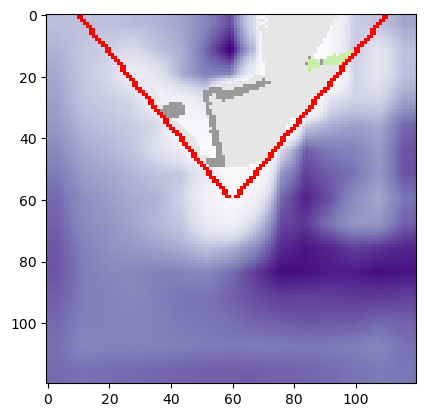

(6, 120, 120)


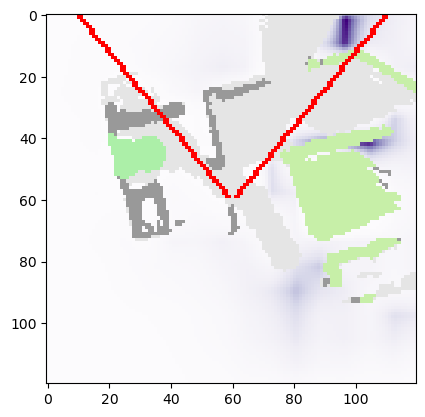

8 4
(6, 120, 120)


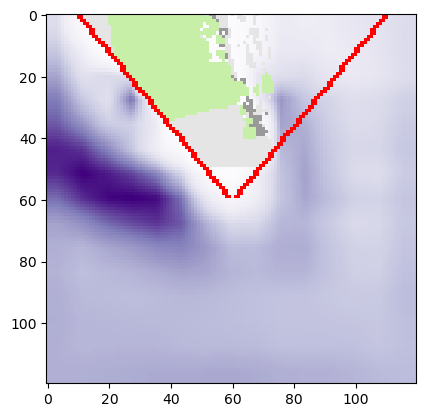

(6, 120, 120)


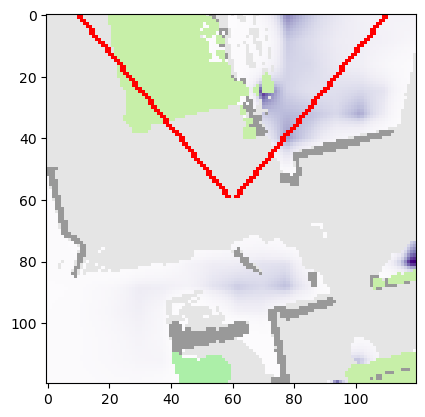

8 8
(6, 120, 120)


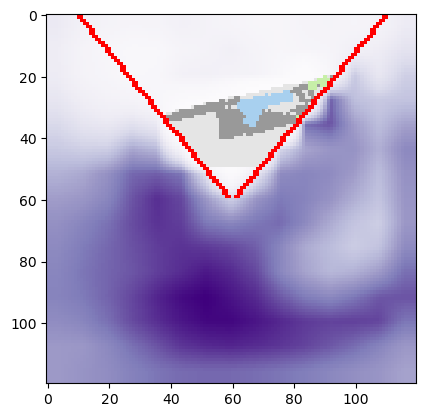

(6, 120, 120)


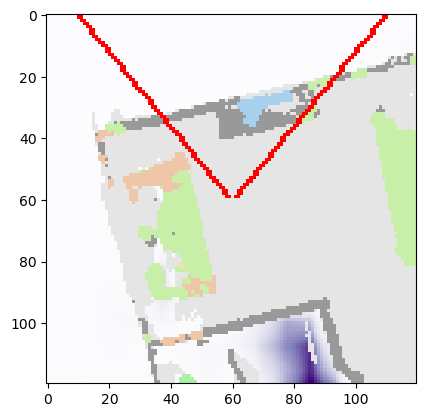

9 0
(6, 120, 120)


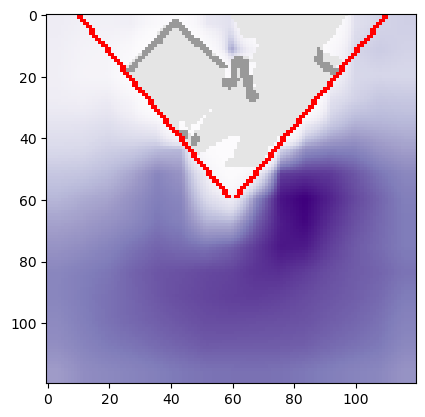

(6, 120, 120)


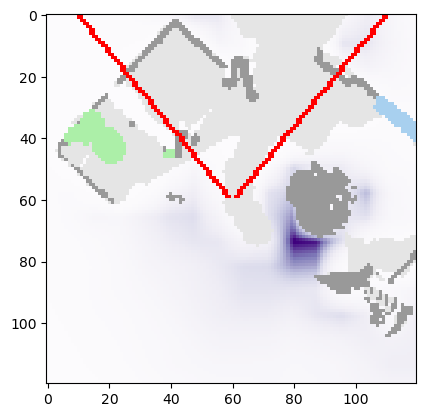

True

In [30]:
np.random.seed(1)
# Save some qualitative results
if not quan:
    for i in [8, 9]:#, 2, 3, 4, 5]:
        for t_idx in range(0, 12, 4):
            print(i, t_idx)
            # Load map file
            mf = np.load( osp.join(data_dir, 'f%05d.npz' % i))['maps']
            vis_mask = mf[t_idx, 3]

            # Get a random crop
            locs = np.where(vis_mask > 0)
            rand_idx = np.random.randint(len(locs[0]))
            rand_dx = np.random.randint(-5, 6)
            rand_dy = np.random.randint(-5, 6)
            center = (min(max(60, locs[0][rand_idx] + rand_dx), vis_mask.shape[0] - 60), 
                      min(max(60, locs[1][rand_idx] + rand_dy), vis_mask.shape[1] - 60))

            result = inference_smp_crop(model,  osp.join(data_dir, 'f%05d.npz' % i), t_idx=t_idx, center=center)

            pred = result[0]
            print(pred.shape)
            gt = mf[:, :, center[0] - cropsize:center[0] + cropsize, 
                    center[1] - cropsize:center[1] + cropsize] / 255.
            z_map = gt[-1, 0]
            obj_map = gt[-1, 4:]
            mask = (gt[t_idx, 1] > 0) * trimask.numpy()
            # visualize_obj_preds(pred, [0, 1, 2, 3, 4, 5], z_map, obj_map, mask)
            # plt.show()
            smv = vis(torch.tensor(gt[t_idx] * mask), torch.tensor(sigmoid(pred[0])))
            # plt.savefig(osp.join(out_dir, 'qual%d_%d.png' % (i, t_idx)))
            # plt.close()

            result_global = inference_smp(model_global,  osp.join(data_dir, 'f%05d.npz' % i), t_idx=t_idx)
            pred = result_global[0][:, center[0] - cropsize:center[0] + cropsize, 
                                    center[1] - cropsize:center[1] + cropsize]
            print(pred.shape)
            gt = mf[:, :, center[0] - cropsize:center[0] + cropsize, 
                    center[1] - cropsize:center[1] + cropsize] / 255.
            z_map = gt[-1, 0]
            obj_map = gt[-1, 4:]
            mask = (gt[t_idx, 1] > 0) #* trimask.numpy()
            smvg = vis(torch.tensor(gt[t_idx]), torch.tensor(sigmoid(pred[0])))
            # visualize_obj_preds(pred, [0, 1, 2, 3, 4, 5], z_map, obj_map, mask)
            # plt.show()
            if i == 9 and t_idx == 0:
                break
cv2.imwrite('../data/vis/ego_pred_vis_9_0.png', smv)
cv2.imwrite('../data/vis/global_pred_vis_9_0.png', smvg)

In [19]:
import skimage.morphology
import matplotlib
from PIL import Image
import cv2


color_palette = [
    1.0, 1.0, 1.0,
    0.6, 0.6, 0.6,
    0.9, 0.9, 0.9,  # formerly 0.95
    0.96, 0.36, 0.26,
    0.12156862745098039, 0.47058823529411764, 0.7058823529411765,
    0.9400000000000001, 0.7818, 0.66,
    0.9400000000000001, 0.8868, 0.66,
    0.8882000000000001, 0.9400000000000001, 0.66,
    0.7832000000000001, 0.9400000000000001, 0.66,
    0.6782000000000001, 0.9400000000000001, 0.66,
    0.66, 0.9400000000000001, 0.7468000000000001,
    0.66, 0.9400000000000001, 0.8518000000000001,
    0.66, 0.9232, 0.9400000000000001,
    0.66, 0.8182, 0.9400000000000001,
    0.66, 0.7132, 0.9400000000000001,
    0.7117999999999999, 0.66, 0.9400000000000001,
    0.8168, 0.66, 0.9400000000000001,
    0.9218, 0.66, 0.9400000000000001,
    0.9400000000000001, 0.66, 0.8531999999999998,
    0.9400000000000001, 0.66, 0.748199999999999,
0.300000000000001, 0.66, 0.8531999999999998,
0.9400000000000001, 0.06, 0.8531999999999998,
0.9400000000000001, 0.66, 0.5531999999999998,
0.3400000000000001, 0.96, 0.2531999999999998,
]

import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
def get_contour_points(pos, origin, size=12):
    x, y, o = pos
    pt1 = (int(x) + origin[0],
           int(y) + origin[1])
    pt2 = (int(x + size / 1.5 * np.cos(o + np.pi * 4 / 3)) + origin[0],
           int(y + size / 1.5 * np.sin(o + np.pi * 4 / 3)) + origin[1])
    pt3 = (int(x + size * np.cos(o)) + origin[0],
           int(y + size * np.sin(o)) + origin[1])
    pt4 = (int(x + size / 1.5 * np.cos(o - np.pi * 4 / 3)) + origin[0],
           int(y + size / 1.5 * np.sin(o - np.pi * 4 / 3)) + origin[1])

    return np.array([pt1, pt2, pt3, pt4])


def vis(m, p, front=None, cmap='Purples', pose=None, g=None, smooth=False, traj=False):
    l = len(p)
    vis_image = np.ones((l, l, 3)).astype(np.uint8) * 255
    
    map_pred = m[0].cpu().numpy()
    exp_pred = m[1].cpu().numpy()
    agent_pos = m[2].cpu().numpy()
    sem_map = m[4:].cpu()
    sem_map[-1] = 1e-5
    sem_map = sem_map.argmax(0).numpy()
    sem_map += 5
    # sem_map[self.collision_map[gx1:gx2, gy1:gy2] == 1] = 14
    # if int(self.stg[0]) < self.local_w and int(self.stg[1]) < self.local_h:
    #     sem_map[int(self.stg[0]),int(self.stg[1])] = 15
    #print(sem_map.shape,self.collision_map[gx1:gx2, gy1:gy2].shape)
    #exit(0)
    no_cat_mask = sem_map == m.shape[0]
    
    map_mask = np.rint(map_pred) == 1
    exp_mask = np.rint(exp_pred) == 1
    
    vis_mask = m[3].cpu().numpy() == 1 #1 TODO: change back
    #vis_mask[self.last_start[0],self.last_start[1]] = True # TODO: delete

    sem_map[no_cat_mask] = 0
    m1 = np.logical_and(no_cat_mask, exp_mask)
    sem_map[m1] = 2
    m2 = np.logical_and(no_cat_mask, map_mask)
    sem_map[m2] = 1

    if traj:
        sem_map[vis_mask] = 3
    
    goal = np.zeros((l, l))
    selem = skimage.morphology.disk(4)
    goal_mat = 1 - skimage.morphology.binary_dilation(
        goal, selem) != True
    #goal_mat = goal

    goal_mask = goal_mat == 1
    sem_map[goal_mask] = 4

    
    color_pal = [int(x * 255.) for x in color_palette]
    sem_map_vis = Image.new("P", (sem_map.shape[1],
                                      sem_map.shape[0]))
    sem_map_vis.putpalette(color_pal)
    sem_map_vis.putdata(sem_map.flatten().astype(np.uint8))
    sem_map_vis = sem_map_vis.convert("RGB")
    sem_map_vis = np.flipud(sem_map_vis)

    sem_map_vis = sem_map_vis[:, :, [2, 1, 0]]
    sem_map_vis = cv2.resize(sem_map_vis, (l, l),
                             interpolation=cv2.INTER_NEAREST)
    my_cm = matplotlib.cm.get_cmap(cmap)
    #p = torch.nn.functional.max_pool2d(p.unsqueeze(0).unsqueeze(0), 7, stride=1, padding=3)[0, 0]
    data = p.cpu().numpy()
    if smooth:
        data = gaussian_filter(data, sigma=5)
    if front is None:
        front = np.ones((l, l))
        white_idx = np.where(np.sum(sem_map_vis, axis=2) == 255 * 3) 
    else:
        front = front.cpu().numpy()
        white_idx = np.where(front[::-1] > 0.1) 
    normed_data = (data - np.min(data)) / (np.max(data) - np.min(data))
    
                                   
    mapped_data = my_cm(normed_data)[::-1, :, [2, 1, 0]] * 255
   
    #white_idx = np.where(np.sum(sem_map_vis, axis=2) == 255 * 3) 
    
    mapped_data_vis = cv2.resize(mapped_data, (l, l),
                         interpolation=cv2.INTER_NEAREST)
    sem_map_vis[white_idx] = mapped_data_vis[white_idx]
    
    if pose is not None:
        start_x, start_y, start_o = pose
        pos = (
                (start_x * 100. / 5 )
                * l / map_pred.shape[0],
                (map_pred.shape[1] - start_y * 100. / 5)
                * l / map_pred.shape[1],
                np.deg2rad(-start_o)
            )

        agent_arrow = get_contour_points(pos, origin=(0, 0))
        color = (int(color_palette[11] * 255),
                 int(color_palette[10] * 255),
                 int(color_palette[9] * 255))
        cv2.drawContours(sem_map_vis, [agent_arrow], 0, color, -1)
        
    if g is not None:
        sz = 7
        # cv2.circle(sem_map_vis, (g[1], l - g[0]), sz, (0, 140, 255), 2)
        cv2.line(sem_map_vis, (g[1] - sz, l - (g[0] - sz)), (g[1] + sz,l - ( g[0] + sz)), (0, 140, 255), 2)
        cv2.line(sem_map_vis, (g[1] - sz, l - (g[0] + sz)), (g[1] + sz, l  - (g[0] - sz)), (0, 140, 255), 2)
        #cv2.line(sem_map_vis, (100, 200), (200, 100), (0, 0, 255), 5)
        
    # sem_map_vis[:2] = 0
    # sem_map_vis[-2:] = 0
    # sem_map_vis[:, :2] = 0
    # sem_map_vis[:, -2:] = 0
    # sem_map_vis[200:250, 50:100] = 255
    sem_map_vis = sem_map_vis[::-1]
    for row in range(0, 60):
        adj = 60 - row
        opp = int(round(np.tan(79/2 * np.pi / 180) * adj))
        sem_map_vis[row, 60 - opp - 1 : 60-opp + 1] = [0, 0, 255]
        sem_map_vis[row, 60 + opp: 60 + opp + 2] = [0, 0, 255]
    plt.imshow(sem_map_vis[:, :, ::-1])
    
    plt.show()
    plt.close()
    return sem_map_vis

In [1]:
# Check Pytorch installation
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
import mmseg
print(mmseg.__version__)

import mmcv
import os.path as osp
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

1.12.0 True
0.26.0


## Train a semantic segmentation model on a new dataset

To train on a customized dataset, the following steps are necessary. 
1. Add a new dataset class. 
2. Create a config file accordingly. 
3. Perform training and evaluation. 

We need to convert the annotation into semantic map format as an image.

In [6]:
import numpy as np

aa = np.ones((4, 7, 7))
rands = np.random.random(size=(7, 7))
pro = aa * rands
print(pro - aa * np.expand_dims(rands, 0))

[[[0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]]]


In [2]:
from mmseg.datasets.builder import PIPELINES

@PIPELINES.register_module()
class LoadMapFromFile(object):
    """Load semantic maps from file.
    Required keys are "img_prefix" and "img_info" (a dict that must contain the
    key "filename"). Added or updated keys are "filename", "img", "img_shape",
    "ori_shape" (same as `img_shape`), "pad_shape" (same as `img_shape`),
    "scale_factor" (1.0) and "img_norm_cfg" (means=0 and stds=1).
    """

    def __init__(self,
                 to_float32=False,
                 file_client_args=dict(backend='disk'),
                 imdecode_backend='np'):
        self.to_float32 = to_float32
        self.file_client_args = file_client_args.copy()
        self.file_client = None
        self.imdecode_backend = imdecode_backend

    def __call__(self, results):
        """Call functions to load image and get image meta information.
        Args:
            results (dict): Result dict from :obj:`mmseg.CustomDataset`.
        Returns:
            dict: The dict contains loaded image and meta information.
        """

        if self.file_client is None:
            self.file_client = mmcv.FileClient(**self.file_client_args)

        if results.get('img_prefix') is not None:
            filename = osp.join(results['img_prefix'],
                                results['img_info']['filename'])
        else:
            filename = results['img_info']['filename']
        maps = np.load(filename)
        img = maps[results['img_info']['t_idx']].transpose(1, 2, 0)
        img = img.astype(np.float32) / 255.

        results['filename'] = filename
        results['ori_filename'] = results['img_info']['filename']
        results['img'] = img
        results['img_shape'] = img.shape
        results['ori_shape'] = img.shape
        # Set initial values for default meta_keys
        results['pad_shape'] = img.shape
        results['scale_factor'] = 1.0
        num_channels = img.shape[0]
        results['img_norm_cfg'] = dict(
            mean=np.zeros(num_channels, dtype=np.float32),
            std=np.ones(num_channels, dtype=np.float32),
            to_rgb=False)
        
        mask = (img[:, :, 1] > 0)
        results['gt_semantic_seg'] = (maps[-1, 4:] * (1 - mask)).transpose(1, 2, 0)
        results['seg_fields'].append('gt_semantic_seg')
        return results

    def __repr__(self):
        repr_str = self.__class__.__name__
        repr_str += f'(to_float32={self.to_float32},'
        repr_str += f"imdecode_backend='{self.imdecode_backend}')"
        return repr_str

In [3]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset
from mmcv.utils import print_log
from mmseg.utils import get_root_logger

@DATASETS.register_module()
class SemMapDataset(CustomDataset):
    CLASSES = ['chair', 'couch', 'potted plant', 'bed', 'toilet', 'tv', 'dining-table', 'oven', 
              'sink', 'refrigerator', 'book', 'clock', 'vase', 'cup', 'bottle']
    PALETTE = None
    def __init__(self, **kwargs):
        super().__init__(img_suffix='.npy', seg_map_suffix='.npy', 
                         split=None, **kwargs)
        assert osp.exists(self.img_dir) 

    def load_annotations(self, img_dir, img_suffix, ann_dir, seg_map_suffix,
                         split):
        """Load annotation from directory.
        Args:
            img_dir (str): Path to image directory
            img_suffix (str): Suffix of images.
            ann_dir (str|None): Path to annotation directory.
            seg_map_suffix (str|None): Suffix of segmentation maps.
            split (str|None): Split txt file. If split is specified, only file
                with suffix in the splits will be loaded. Otherwise, all images
                in img_dir/ann_dir will be loaded. Default: None
        Returns:
            list[dict]: All image info of dataset.
        """

        img_infos = []

        for img in self.file_client.list_dir_or_file(
                dir_path=img_dir,
                list_dir=False,
                suffix=img_suffix,
                recursive=True):
            for t_idx in range(4):
                img_info = dict(filename=img)
                img_info['t_idx'] = t_idx
                # if ann_dir is not None:
                #     seg_map = img.replace(img_suffix, seg_map_suffix)
                #     img_info['ann'] = dict(seg_map=seg_map)
                img_infos.append(img_info)
        
        img_infos = sorted(img_infos, key=lambda x: x['filename'])

        print_log(f'Loaded {len(img_infos)} images', logger=get_root_logger())
        return img_infos
    
    def get_ann_info(self, idx):
        """Get annotation by index.
        Args:
            idx (int): Index of data.
        Returns:
            dict: Annotation info of specified index.
        """

        return None

In [4]:
from mmseg.models.builder import LOSSES
from mmseg.models.losses.utils import weighted_loss

@weighted_loss
def my_loss(pred, target):
    target = torch.permute(target, (0, 3, 1, 2))
    assert pred.size() == target.size() and target.numel() > 0
    loss = F.binary_cross_entropy_with_logits(pred, target / 255., reduction='none')
    return loss

@LOSSES.register_module
class MyLoss(nn.Module):

    def __init__(self, reduction='mean', loss_weight=1.0):
        super(MyLoss, self).__init__()
        self.reduction = reduction
        self.loss_weight = loss_weight

    def forward(self,
                pred,
                target,
                weight=None,
                avg_factor=None,
                reduction_override=None,
                ignore_index=None):
        assert reduction_override in (None, 'none', 'mean', 'sum')
        reduction = (
            reduction_override if reduction_override else self.reduction)
        loss = self.loss_weight * my_loss(
            pred, target, weight, reduction=reduction, avg_factor=avg_factor)
        return loss
    
    @property
    def loss_name(self):
        return 'loss_bce'

# TODO: add BCE loss, update all parts of config below

### Create a config file
In the next step, we need to modify the config for the training. To accelerate the process, we finetune the model from trained weights.

In [5]:
from mmcv import Config
cfg = Config.fromfile('configs/pspnet/pspnet_r18-d8_512x1024_80k_cityscapes.py')

Since the given config is used to train PSPNet on the cityscapes dataset, we need to modify it accordingly for our new dataset.  

In [9]:
import torch
torch.sigmoid(torch.tensor(-0.05))

tensor(0.4875)

In [6]:
from mmseg.apis import set_random_seed
from mmseg.utils import get_device

# Since we use only one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg

cfg.model.backbone.in_channels = 20

# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 16
cfg.model.auxiliary_head.num_classes = 16

cfg.model.decode_head.loss_decode = dict(type='MyLoss', loss_weight=1.0)
cfg.model.auxiliary_head.loss_decode = dict(type='MyLoss', loss_weight=0.4)

# Modify dataset type and path
cfg.dataset_type = 'SemMapDataset'
cfg.data_root = '../data/saved_maps'

cfg.data.samples_per_gpu = 8
cfg.data.workers_per_gpu = 4

cfg.img_norm_cfg = dict(
    mean=[0, 0, 0], std=[1 ,1, 1], to_rgb=True)

cfg.crop_size = (720, 720)
cfg.train_pipeline = [
    dict(type='LoadMapFromFile'),
    # dict(type='Resize', img_scale=(320, 240), ratio_range=(0.5, 2.0)),
    dict(type='Pad', size=(960, 960), pad_val=0, seg_pad_val=0),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=1.),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='RandomRotate', prob=1., degree=180, pad_val=0, seg_pad_val=0),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadMapFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=None,
        img_ratios=[1.],
        flip=False,
        transforms=[
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]


cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = 'train'
cfg.data.train.ann_dir = None
cfg.data.train.pipeline = cfg.train_pipeline

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = 'val'
cfg.data.train.ann_dir = None
cfg.data.val.pipeline = cfg.test_pipeline

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = 'val'
cfg.data.train.ann_dir = None
cfg.data.test.pipeline = cfg.test_pipeline

cfg.load_from = './work_dirs/tutorial/latest.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/tutorial'

cfg.runner.max_iters = 20
cfg.log_config.interval = 10
cfg.evaluation.interval = 500
cfg.checkpoint_config.interval = 200

# Set seed to facitate reproducing the result
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)
cfg.device = get_device()

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained='open-mmlab://resnet18_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=18,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 2, 4),
        strides=(1, 2, 1, 1),
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True,
        in_channels=20),
    decode_head=dict(
        type='PSPHead',
        in_channels=512,
        in_index=3,
        channels=128,
        pool_scales=(1, 2, 3, 6),
        dropout_ratio=0.1,
        num_classes=16,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(type='MyLoss', loss_weight=1.0)),
    auxiliary_head=dict(
        type='FCNHead',
        in_channels=256,
        in_index=2,
        channels=64,
        num_convs=1,
        concat_input=False,
        dropou

### Train and Evaluation

In [7]:



# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(cfg.model)
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
model.train()
train_segmentor(model, datasets, cfg, distributed=False, validate=True, 
                meta=dict())

2022-07-17 18:54:53,430 - mmseg - INFO - Loaded 3200 images
/home/azhai/smpred/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
2022-07-17 18:54:55,167 - mmseg - INFO - Loaded 2000 images
2022-07-17 18:54:55,168 - mmseg - INFO - load checkpoint from local path: ./work_dirs/tutorial/latest.pth
2022-07-17 18:54:55,220 - mmseg - INFO - Start running, host: azhai@azhai-Z390-UD, work_dir: /home/azhai/smpred/mmsegmentation/work_dirs/tutorial
2022-07-17 18:54:55,221 - mmseg - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) PolyLrUpdaterHook                  


Inference with trained model

In [8]:
from mmseg.datasets.pipelines import Compose
from mmcv.parallel import collate, scatter

def inference_smp(model, imgfile, t_idx):
    """Inference image(s) with the segmentor.
    Args:
        model (nn.Module): The loaded segmentor.
        imgs (str/ndarray or list[str/ndarray]): Either image files or loaded
            images.
    Returns:
        (list[Tensor]): The segmentation result.
    """
    cfg = model.cfg
    device = next(model.parameters()).device  # model device
    img_info = dict(filename = imgfile, t_idx = t_idx)
    # prepare data
    test_pipeline = Compose(cfg.data.test.pipeline)
    data = dict(img_info=img_info, seg_fields=[])
    data = test_pipeline(data)
    data = collate([data], samples_per_gpu=1)
    if next(model.parameters()).is_cuda:
        # scatter to specified GPU
        data = scatter(data, [device])[0]
    else:
        data['img_metas'] = [i.data[0] for i in data['img_metas']]

    # forward the model
    with torch.no_grad():
        result = model(return_loss=False, rescale=True, **data)
    return result

model.cfg = cfg
model.eval()
result = inference_smp(model, '../data/saved_maps/val/f00000.npy', t_idx=2)
print(result[0].shape)

(16, 720, 720)


In [ ]:
img = mmcv.imread('iccv09Data/images/6000124.jpg')

model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, result, palette)

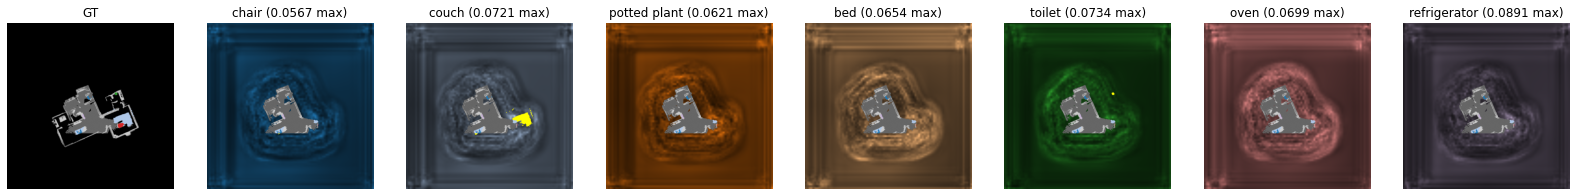

In [12]:

id_color = np.array(
    [
        [31, 119, 180],
        [174, 199, 232],
        [255, 127, 14],
        [255, 187, 120],
        [44, 160, 44],
        [152, 223, 138],
        [214, 39, 40],
        [255, 152, 150],
        [148, 103, 189],
        [197, 176, 213],
        [140, 86, 75],
        [196, 156, 148],
        [227, 119, 194],
        [247, 182, 210],
#         [127, 127, 127],
#         [199, 199, 199],
        [188, 189, 34],
        [219, 219, 141],
        [23, 190, 207],
        [158, 218, 229],
        [57, 59, 121],
        [82, 84, 163],
        [107, 110, 207],
        [156, 158, 222],
        [99, 121, 57],
        [140, 162, 82],
        [181, 207, 107],
        [206, 219, 156],
        [140, 109, 49],
        [189, 158, 57],
        [231, 186, 82],
        [231, 203, 148],
        [132, 60, 57],
        [173, 73, 74],
        [214, 97, 107],
        [231, 150, 156],
        [123, 65, 115],
        [165, 81, 148],
        [206, 109, 189],
        [222, 158, 214],
    ],
    dtype=np.uint8,
)

common_cls = ['chair', 'couch', 'potted plant', 'bed', 'toilet', 'tv', 'dining-table', 'oven', 
              'sink', 'refrigerator', 'book', 'clock', 'vase', 'cup', 'bottle']

def visualize_obj_preds(pred, cls_ids, z_map, obj_map, mask):
    pred = torch.sigmoid(pred[cls_ids]).cpu().numpy()
    max_p = np.array([np.max(p) for p in pred])
    for i in range(len(cls_ids)):
        pred[i] /= max_p[i]
    
    z_map = z_map
    obj_map = obj_map
    mask = mask
    rgb = np.zeros((pred[0].shape[0], pred[0].shape[1], 3), dtype=float)
    for i in range(rgb.shape[0]):
        for j in range(rgb.shape[1]):
            rgb[i, j] = z_map[i, j]  * 0.8
            if np.sum(obj_map[:, i, j]) > 0:
                rgb[i, j] = id_color[np.argmax(obj_map[:, i, j])]/255 
            elif mask[i, j]:
                rgb[i, j] = max(rgb[i, j][0], 0.4)
    
    fig, axs = plt.subplots(1, len(cls_ids) + 1, figsize=(4* len(cls_ids), 4))
    axs[0].imshow(np.clip(rgb, 0, 1))
    axs[0].set_title('GT')
    axs[0].axis('off')
    for c in range(len(cls_ids)):
        pred_rgb = np.copy(rgb)
        pred_rgb[np.logical_not(mask.astype(bool))] = 0
        for i in range(rgb.shape[0]):
            for j in range(rgb.shape[1]):
                if mask[i, j] < 1:
                    pred_rgb[i, j] += pred[c, i, j] * id_color[cls_ids[c]]/255
                    if np.argmax(obj_map[:, i, j]) == cls_ids[c] and np.sum(obj_map[:, i, j]):
                        pred_rgb[i, j] = [1, 1, 0]
        axs[c + 1].imshow(np.clip(pred_rgb, 0, 1))
        axs[c + 1].axis('off')
        axs[c + 1].set_title('%s (%.4f max)' % (common_cls[cls_ids[c]], max_p[c]))
    
    
xd = np.load('../data/saved_maps/val/f00000.npy') / 255.
z_map = xd[-1, 0]
obj_map = xd[-1, 4:]
mask = xd[2, 1] > 0
visualize_obj_preds(torch.tensor(result[0]), [0, 1, 2, 3, 4, 7, 9], z_map, obj_map, mask)